In [1]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
# nltk.download('wordnet')
# nltk.download('punkt')

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

print("Number of data points in training data:", df_train.shape[0])
print("Number of data points in test data:", df_test.shape[0])

Number of data points in training data: 1306122
Number of data points in test data: 375806


In [4]:
# Replacing math equations and url addresses with tags.
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

In [5]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
    return x

In [6]:
# remove stopwords
def remove_stopwords(x):
  x = [word for word in x.split() if word not in STOPWORDS]
  x = ' '.join(x)

  return x

# word lemmatizing
lemmatizer = WordNetLemmatizer()
def lemma_text(x):
  x = x.split()
  x = [lemmatizer.lemmatize(word) for word in x]
  x = ' '.join(x)

  return x

In [7]:
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = remove_stopwords(x)
  x = lemma_text(x)
  return x

In [8]:
# preprocessing given train and test data
df_train['preprocessed_question_text'] = df_train['question_text'].map(lambda x: data_cleaning(x))
df_test['preprocessed_question_text'] = df_test['question_text'].map(lambda x: data_cleaning(x))

In [9]:
# Number of words
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))

# Number of capital_letters
df_train['num_capital_let'] = df_train['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
df_test['num_capital_let'] = df_test['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of unique words
df_train['num_unique_words'] = df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['num_unique_words'] = df_test['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of characters
df_train['num_char'] = df_train['question_text'].apply(lambda x: len(str(x)))
df_test['num_char'] = df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['num_stopwords'] = df_train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
df_test['num_stopwords'] = df_test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

df_train.head()

,qid,question_text,target,preprocessed_question_text,num_words,num_capital_let,num_unique_words,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How Quebec nationalist see province nation 1960s?,13,2,13,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do adopted dog encourage people adopt shop?,16,1,15,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why velocity affect time? Does velocity affect...,10,2,8,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,How Otto von Guericke used Magdeburg hemispheres?,9,4,9,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,Can I convert montra helicon D mountain bike c...,15,3,15,77,7


In [10]:
y = df_train['target'].values
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2019)

print('X_train: ', X_train.shape, y_train.shape)
print('X_test: ',X_test.shape, y_test.shape)
print('X_val: ',X_val.shape, y_val.shape)

X_train:  (940407, 9) (940407,)
X_test:  (261225, 9) (261225,)
X_val:  (104490, 9) (104490,)


In [11]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf.fit_transform(list(df_train['preprocessed_question_text'].values) + list(df_test['preprocessed_question_text'].values))

X_train_ques = tfidf.transform(X_train['preprocessed_question_text'].values)
X_test_ques = tfidf.transform(X_test['preprocessed_question_text'].values)
X_val_ques = tfidf.transform(X_val['preprocessed_question_text'].values)

print(X_train_ques.shape)
print(X_test_ques.shape)
print(X_val_ques.shape)

(940407, 10159988)
(261225, 10159988)
(104490, 10159988)


In [12]:

# number of words
num_words =  StandardScaler()
X_train_num_words = num_words.fit_transform(X_train['num_words'].values.reshape(-1, 1))
X_test_num_words = num_words.transform(X_test['num_words'].values.reshape(-1, 1))
X_val_num_words = num_words.transform(X_val['num_words'].values.reshape(-1, 1))

# number of unique words
num_unique_words =  StandardScaler()
X_train_num_unique_words = num_unique_words.fit_transform(X_train['num_unique_words'].values.reshape(-1, 1))
X_test_num_unique_words = num_unique_words.transform(X_test['num_unique_words'].values.reshape(-1, 1))
X_val_num_unique_words = num_unique_words.transform(X_val['num_unique_words'].values.reshape(-1, 1))

# number of char
num_char =  StandardScaler()
X_train_num_char = num_char.fit_transform(X_train['num_char'].values.reshape(-1, 1))
X_test_num_char = num_char.transform(X_test['num_char'].values.reshape(-1, 1))
X_val_num_char = num_char.transform(X_val['num_char'].values.reshape(-1, 1))

# number of stopwords
num_stopwords =  StandardScaler()
X_train_num_stopwords = num_stopwords.fit_transform(X_train['num_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords = num_stopwords.transform(X_test['num_stopwords'].values.reshape(-1, 1))
X_val_num_stopwords = num_stopwords.transform(X_val['num_stopwords'].values.reshape(-1, 1))

In [13]:
# Stacking features 

X_tr = hstack((
    X_train_ques,
    X_train_num_words,
    X_train_num_unique_words,
    X_train_num_char,
    X_train_num_stopwords
))

X_te = hstack((
    X_test_ques,
    X_test_num_words,
    X_test_num_unique_words,
    X_test_num_char,
    X_test_num_stopwords
))

X_cv = hstack((
    X_val_ques,
    X_val_num_words,
    X_val_num_unique_words,
    X_val_num_char,
    X_val_num_stopwords
))

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print(X_cv.shape, y_val.shape)

(940407, 10159992) (940407,)
(261225, 10159992) (261225,)
(104490, 10159992) (104490,)


In [20]:
y_train = y_train.astype(float)

In [22]:
import cupy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# # Convert data to cupy arrays if not already in cupy format
# X_tr_gpu = cp.array(X_tr)
# y_train_gpu = cp.array(y_train)

parmas = {'C': [0.001, 0.001, 0.1, 1, 10]}

# Use solver='sag' to enable GPU acceleration
gridsearch = GridSearchCV(LogisticRegression(solver='sag', max_iter=1000), parmas, scoring='f1', n_jobs=-1, verbose=1)
gridsearch.fit(X_tr, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\Shantanu.LAPTOP-BEECR776\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='sag'),
             n_jobs=-1, param_grid={'C': [0.001, 0.001, 0.1, 1, 10]},
             scoring='f1', verbose=1)

In [23]:
gridsearch.best_params_

{'C': 10}

In [25]:
clf = LogisticRegression(C=10,solver='sag', max_iter=1000 )
clf.fit(X_tr, y_train)

c:\Users\Shantanu.LAPTOP-BEECR776\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, max_iter=1000, solver='sag')

In [29]:
y_pred_val = clf.predict_proba(X_cv)[:,1]

for t in np.arange(0.1, 0.301, 0.01):
  t = np.round(t, 2)
  print('F1 score at threshold {0} is {1}'.format(t, f1_score(y_val, (y_pred_val>t).astype('int'))))

F1 score at threshold 0.1 is 0.5823638509526218
F1 score at threshold 0.11 is 0.5902858470834301
F1 score at threshold 0.12 is 0.5974555928948632
F1 score at threshold 0.13 is 0.6
F1 score at threshold 0.14 is 0.6043211049863777
F1 score at threshold 0.15 is 0.604829287290666
F1 score at threshold 0.16 is 0.6047808764940239
F1 score at threshold 0.17 is 0.6076568015204996
F1 score at threshold 0.18 is 0.6090085103438733
F1 score at threshold 0.19 is 0.6098471508065084
F1 score at threshold 0.2 is 0.6086894178376828
F1 score at threshold 0.21 is 0.6071037852818905
F1 score at threshold 0.22 is 0.6052163604030824
F1 score at threshold 0.23 is 0.6029522518451574
F1 score at threshold 0.24 is 0.5985300872760679
F1 score at threshold 0.25 is 0.5961210240496508
F1 score at threshold 0.26 is 0.5942803268384663
F1 score at threshold 0.27 is 0.5902578796561605
F1 score at threshold 0.28 is 0.5863486179385929
F1 score at threshold 0.29 is 0.5820822454308094
F1 score at threshold 0.3 is 0.5779135

In [30]:
t = 0.19
y_pred_test = clf.predict_proba(X_te)[:,1]
print('F1-Score: ', round(f1_score(y_test, (y_pred_test>t)), 5))

F1-Score:  0.6046


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [33]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()
  
  print(f"Correctly classified sincere questions: {round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}%")
  print(f"Correctly classified insincere questions: {round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}%")

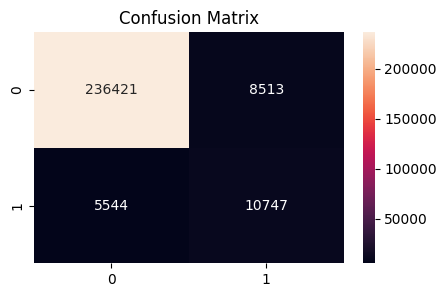

Correctly classified sincere questions: 96.52%
Correctly classified insincere questions: 65.97%


In [34]:
plot_confusion_matrix(y_test, (y_pred_test>t))

In [35]:
print(classification_report(y_test, (y_pred_test>t)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    244934
           1       0.56      0.66      0.60     16291

    accuracy                           0.95    261225
   macro avg       0.77      0.81      0.79    261225
weighted avg       0.95      0.95      0.95    261225



In [36]:
import pickle
from sklearn.linear_model import LogisticRegression

# Save the coefficients to a file
with open('logistic_regression_weights.pkl', 'wb') as f:
    pickle.dump(clf.coef_, f)